In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    column = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for col in column:
        df = create_dummies(df,col)
    
    return df
train = pre_process(train)
holdout = pre_process(holdout)
    

In [5]:
columns = ['SibSp', 'Parch', 'Survived']
explore = train[columns].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


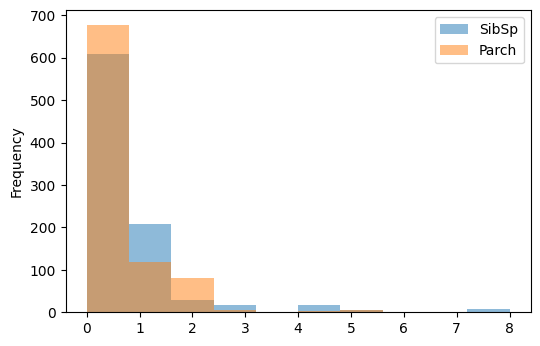

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop(['Survived'], axis=1).plot.hist(alpha=0.5)


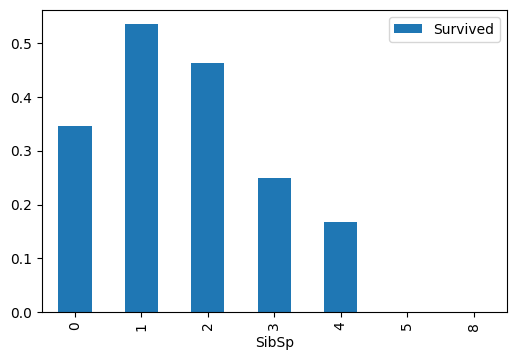

In [18]:
var = explore.pivot_table(index='SibSp', values='Survived')
var.plot(kind='bar')

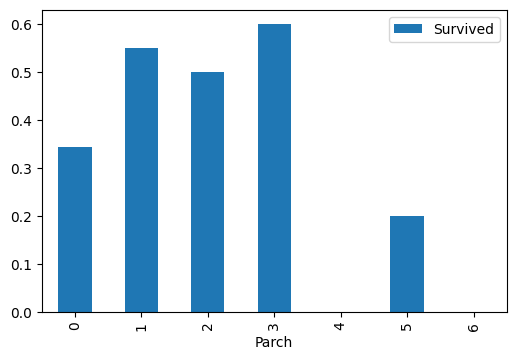

In [19]:
var = explore.pivot_table(index='Parch', values='Survived')
var.plot(kind='bar')

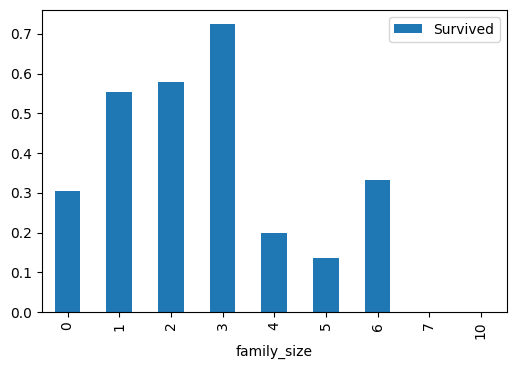

In [20]:
explore['family_size']= explore[['SibSp', 'Parch']].sum(axis=1)
pivot = explore.pivot_table(index='family_size', values='Survived')
pivot.plot.bar()

In [27]:
def process_isalone(df):
    df['family_size'] = df[['SibSp','Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['family_size']==0), 'isalone']=1
    df = df.drop(['family_size'], axis=1)
    return df
train = process_isalone(train)
holdout = process_isalone(holdout)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import numpy as np
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['Survived','PassengerId'],axis=1)
    all_y = df['Survived']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X, all_y)
    best_cols = list(all_X.columns[selector.support_])
    print(best_cols)
    return best_cols
best_train = select_features(train)
    

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    models = [{'name':'LogisticRegression',
               'estimator':LogisticRegression(),
               'hyperparameters':{
                    'solver':["newton-cg", "lbfgs", "liblinear"]
                                  } 
               },
              { 'name':'KNeighborsClassifier',
                'estimator':KNeighborsClassifier(),
                'hyperparameters':{
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]    }
                },
               { 'name':'RandomForestClassifier',
                 'estimator':RandomForestClassifier(),
                 'hyperparameters':{
                     "n_estimators": [4, 6, 9],
                     "criterion": ["entropy", "gini"],
                     "max_depth": [2, 5, 10],
                     "max_features": ["log2", "sqrt"],
                     "min_samples_leaf": [1, 5, 8],
                     "min_samples_split": [2, 3, 5]
                                  }
               }
                  ]
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_params']=grid.best_params_
        model['best_score']=grid.best_score_
        model['best_model']=grid.best_estimator_
        print('Best Score : {}'.format(model['best_score']))
        print('Best Parameter : {}\n'.format(model['best_params']))
    return models
result = select_model(train,best_train)

    

LogisticRegression
------------------


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

Best Score : 0.8204744069912608
Best Parameter : {'solver': 'lbfgs'}

KNeighborsClassifier
--------------------
Best Score : 0.7767041198501874
Best Parameter : {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score : 0.8373533083645442
Best Parameter : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 4}



In [60]:
def save_submission_file(model,col_list,filename='submission.csv'):
    holdout_data = holdout[col_list]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout['PassengerId']
    submission_df = {'PassengerID':holdout_ids,
                    'Survived':predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv('submission.csv', index=False)

best_rf_model = result[2]['best_model']   
save_submission_file(best_rf_model,best_train)